# Zaman Serisi Analizi
TÜİK üzerinden aldığımız İzmir şehrinin elektrik fiyatları verisiyle Pandas Profiling ve Prophet kütüphanelerini kullanarak bir zaman serisi analizi gerçekleştireceğiz. 

In [1]:
# gerekli kütüphaneler
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ydata_profiling
import re
import datetime
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [2]:
# verinin yüklenmesi
df = pd.read_csv('izmir.csv', sep='|', header=None, skiprows=4)

In [3]:
df.head()

,0,1,2,3,4
0,2005.0,01-Ocak,0441001. (Su Faturası),2.1807,NaN
1,NaN,NaN,0451001. (Elektrik Ücreti),0.1600,NaN
2,NaN,NaN,0452101. (Doğal Gaz),0.0000,NaN
3,NaN,NaN,0722001. (Benzin),2.3294,NaN
4,NaN,NaN,0830009. (İnternet Ücreti),13.6864,NaN


## Veri Ön İşleme
İlk olarak 4 numaralı sadece NaN değerlerden oluşan sutunu verimizden atalım.

In [4]:
print(df[4])
df[4].isna().sum()

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1036   NaN
1037   NaN
1038   NaN
1039   NaN
1040   NaN
Name: 4, Length: 1041, dtype: float64


1041

Görüldüğü üzere 1041 satırın hepsi NaN değerleden oluşmakta, bu sutundan kurtulalım.

In [5]:
df.drop(axis=1, columns=[4], inplace=True)

In [6]:
# verideki sutunları isimlendirelim
sutunlar = ['Yıl', 'Ay', 'Ürün', 'Fiyat']
df.columns = sutunlar

In [7]:
# boş değerleri bir önceki değer ile dolduralım
df = df.fillna(method="ffill")

<b>Regex ile Ürün sutunundaki gereksiz sayılardan kurtulalım</b>

In [8]:
pattern = r".* \((.*)\)+"
df["Ürün"] = df["Ürün"].apply(lambda x: re.search(pattern, x).group(1))
df["Ürün"] = df["Ürün"].apply(lambda x: x.replace(')',''))

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Yıl     1041 non-null   float64
 1   Ay      1041 non-null   object 
 2   Ürün    1041 non-null   object 
 3   Fiyat   1041 non-null   float64
dtypes: float64(2), object(2)
memory usage: 32.7+ KB


Tarih verilerini işleyerek "Yıl" ve "Ay" sütunlarını güncelleyelim ve veri setinin genel bir profilini Pandas Profiling ile çıkaralım.

In [10]:
df["Yıl"] = df["Yıl"].astype(int)
df["Ay"] = df["Ay"].apply(lambda x: int(str(x)[:2]))
ydata_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Profiling kütüphanesi ile veri setimizdeki birçok önemli bilgiye ve betimsel istatistiklerine kolayca ulaşabiliriz.

In [11]:
# veriye genel bir bakis
df

,Yıl,Ay,Ürün,Fiyat
0,2005,1,Su Faturası,2.1807
1,2005,1,Elektrik Ücreti,0.1600
2,2005,1,Doğal Gaz,0.0000
3,2005,1,Benzin,2.3294
4,2005,1,İnternet Ücreti,13.6864
...,...,...,...,...
1036,2022,4,Elektrik Ücreti,1.3372
1037,2022,4,Doğal Gaz,3.6486
1038,2022,4,Benzin,19.1860
1039,2022,4,İnternet Ücreti,81.5053


Verimizi daha okunaklı kılmak için "Ürün", "Yıl", ve "Ay" sütunlarındaki verileri kullanarak bir pivot tablosu oluşturalım.

In [12]:
df_pivot = df.pivot_table("Fiyat",["Yıl","Ay"],"Ürün")
df_pivot

Ürün      Benzin  Doğal Gaz  Elektrik Ücreti  Su Faturası  İnternet Ücreti
Yıl  Ay                                                                   
2005 1    2.3294     0.0000           0.1600       2.1807          13.6864
     2    2.3520     0.0000           0.1600       2.1807          13.6917
     3    2.4124     0.0000           0.1600       2.1807          13.6917
     4    2.5359     0.0000           0.1600       2.0857          13.9496
     5    2.4933     0.0000           0.1600       2.0857          14.2074
...          ...        ...              ...          ...              ...
2021 12  10.7949     2.2639           0.9172       7.4228          75.3537
2022 1   13.7095     2.7198           1.5562       8.8448          76.2700
     2   15.2458     2.7874           1.4809       8.6666          77.5432
     3   19.0004     2.8502           1.3372      10.8372          79.0905
     4   19.1860     3.6486           1.3372      11.5700          81.5053

[208 rows x 5 columns]

In [13]:
# korelasyon
corr = df_pivot.corr()

print(corr.unstack())
corr

Ürün             Ürün           
Benzin           Benzin             1.000000
                 Doğal Gaz          0.874298
                 Elektrik Ücreti    0.932985
                 Su Faturası        0.908011
                 İnternet Ücreti    0.332658
Doğal Gaz        Benzin             0.874298
                 Doğal Gaz          1.000000
                 Elektrik Ücreti    0.942101
                 Su Faturası        0.949328
                 İnternet Ücreti    0.329421
Elektrik Ücreti  Benzin             0.932985
                 Doğal Gaz          0.942101
                 Elektrik Ücreti    1.000000
                 Su Faturası        0.938790
                 İnternet Ücreti    0.349674
Su Faturası      Benzin             0.908011
                 Doğal Gaz          0.949328
                 Elektrik Ücreti    0.938790
                 Su Faturası        1.000000
                 İnternet Ücreti    0.310830
İnternet Ücreti  Benzin             0.332658
                 Doğal

Ürün,Benzin,Doğal Gaz,Elektrik Ücreti,Su Faturası,İnternet Ücreti
Ürün,,,,,
Benzin,1.000000,0.874298,0.932985,0.908011,0.332658
Doğal Gaz,0.874298,1.000000,0.942101,0.949328,0.329421
Elektrik Ücreti,0.932985,0.942101,1.000000,0.938790,0.349674
Su Faturası,0.908011,0.949328,0.938790,1.000000,0.310830
İnternet Ücreti,0.332658,0.329421,0.349674,0.310830,1.000000


         Ürün 1          Ürün 2  Korelasyon
      Doğal Gaz     Su Faturası    0.949328
      Doğal Gaz Elektrik Ücreti    0.942101
Elektrik Ücreti     Su Faturası    0.938790
         Benzin Elektrik Ücreti    0.932985
         Benzin     Su Faturası    0.908011
         Benzin       Doğal Gaz    0.874298
Elektrik Ücreti İnternet Ücreti    0.349674
         Benzin İnternet Ücreti    0.332658
      Doğal Gaz İnternet Ücreti    0.329421
    Su Faturası İnternet Ücreti    0.310830


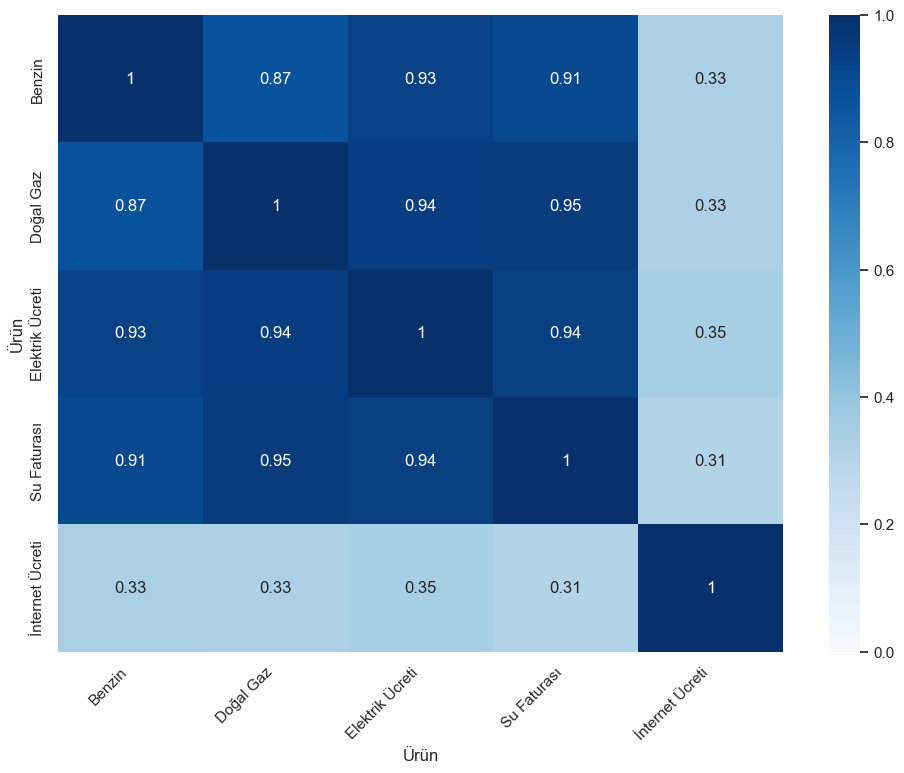

In [14]:
sns.set(rc={"figure.figsize":(11.7,8.27)})

corr = df_pivot.corr()
ax = sns.heatmap(corr, 
                 cmap="Blues", 
                 vmax=1, 
                 vmin=0, 
                 center=0.5, 
                 annot=True)

ax.set_xticklabels(corr.index, horizontalalignment = "right", rotation=45)

stack = corr.unstack()
stack_sorted = stack[stack != 1].sort_values(kind="quicksort", ascending=False)

stack_sorted.index.names = ["Ürün 1", "Ürün 2"]
stack_sorted = stack_sorted.reset_index()
stack_sorted = stack_sorted[stack_sorted["Ürün 1"] < stack_sorted["Ürün 2"]]
stack_sorted = stack_sorted.rename(columns={0: "Korelasyon"})
print(stack_sorted.to_string(index=False))

<b>İlk 6 satırdaki ilişkinin çok yüksek olduğunu söyleyebiliriz.</b>

## Zaman Serileri

In [15]:
# sadece elektrik ücretlerine bakalım
df = df.loc[df["Ürün"] == "Elektrik Ücreti"]
df

,Yıl,Ay,Ürün,Fiyat
1,2005,1,Elektrik Ücreti,0.1600
6,2005,2,Elektrik Ücreti,0.1600
11,2005,3,Elektrik Ücreti,0.1600
16,2005,4,Elektrik Ücreti,0.1600
21,2005,5,Elektrik Ücreti,0.1600
...,...,...,...,...
1016,2021,12,Elektrik Ücreti,0.9172
1021,2022,1,Elektrik Ücreti,1.5562
1026,2022,2,Elektrik Ücreti,1.4809
1031,2022,3,Elektrik Ücreti,1.3372


#### Hedef değişkenimiz olan elektrik ücretinin yıllara göre çizgi grafiğini çizdirelim.

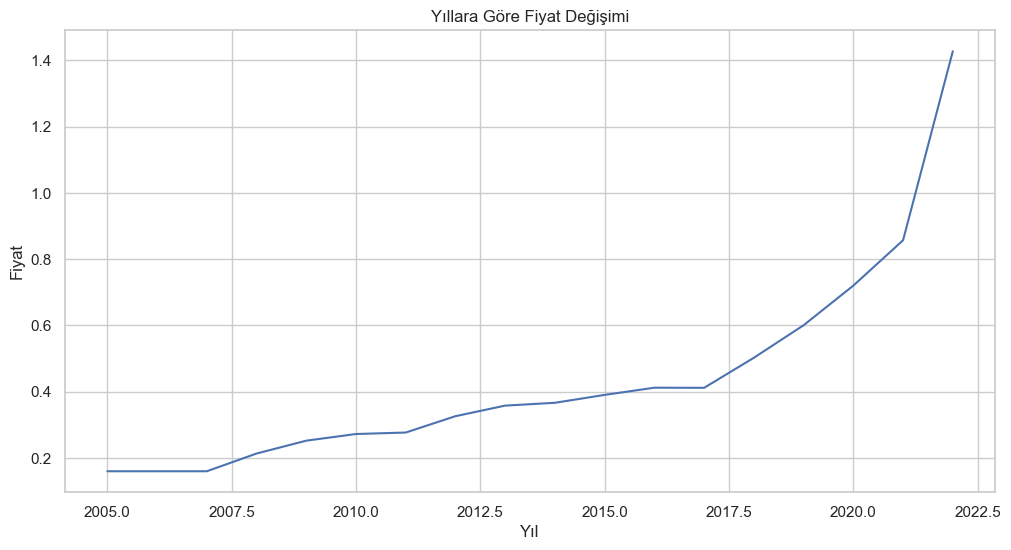

In [16]:
df["Tarih"] = df["Yıl"].astype(str) + "-" + df["Ay"].astype(str) + "-01"
df["Tarih"] = pd.to_datetime(df["Tarih"])

yillik_artis = df.groupby(df["Tarih"].dt.year)["Fiyat"].mean().reset_index()

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=yillik_artis, x="Tarih", y="Fiyat")
plt.title("Yıllara Göre Fiyat Değişimi")
plt.xlabel("Yıl")
plt.ylabel("Fiyat")
plt.show()

<b>Elektrik ücretlerinin yıllar içindeki değişimini gösteren grafiğe baktığımızda fiyat değişkeninin artan bir trend izlediğini söyleyebiliriz. Özellikle 2021 yılında eğrinin oldukça dikleştiğini bunun sonucu olarak da elektrik ücretlerine diğer yıllara oranla yüksek zamların geldiği söylenebilir.</b>

## Date Mapping İşlemi
Prophet, Facebook tarafından zaman serisi tahminlemeleri için geliştirilmiş bir kütüphanedir. Prophet kütüphanesini kullanabilmek için en az iki sutun (ds ve y) gerekmektedir.

+ ds (datestamp): Zaman damgası veya tarih bilgisi içeren bir sütun olmalı. Bu sütun genellikle pandas tarih formatında (datetime64[ns]) olmalıdır.
+ y: Tahmin edilecek değişkenin sütunu. Bu sütun, float veya integer tipinde olabilir.

Bizde verimizi data mapping işlemi ile istenilen formata getireceğiz.

In [17]:
def date_mapping(row):
    return datetime.date(row["Yıl"], row["Ay"], 1)

In [18]:
df["Tarih"] = df.apply(lambda x: date_mapping(x), axis=1)
df_sub = df[["Tarih", "Fiyat"]].reset_index(drop=True)
df_sub.head()

,Tarih,Fiyat
0,2005-01-01,0.16
1,2005-02-01,0.16
2,2005-03-01,0.16
3,2005-04-01,0.16
4,2005-05-01,0.16


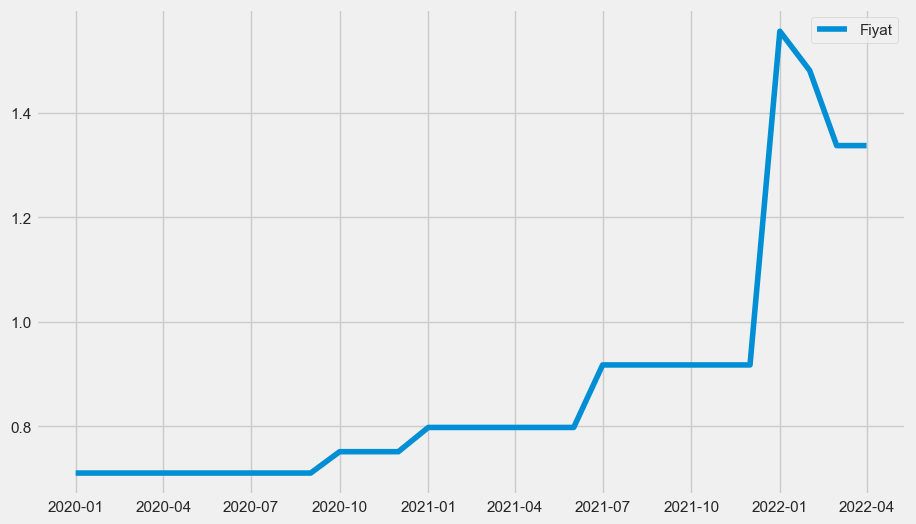

In [19]:
plt.style.use("fivethirtyeight")
pd.plotting.register_matplotlib_converters()
fig = plt.figure(figsize=(10,6))
df_sub2 = df[df["Yıl"] >= 2020].reset_index(drop=True)
df_sub2["Tarih"] = df_sub2.apply(lambda x: date_mapping(x), axis=1)
plt.plot(df_sub2.Tarih, df_sub2.Fiyat)

plt.legend(["Fiyat"])

<b>Yakın tarihli artış trendi bu şelilde, 2021'in sonlarında hızlı bir artış olmuş ve 2022 başı itibariyle de bir miktar düşüş yaşandığı görülüyor.</b>

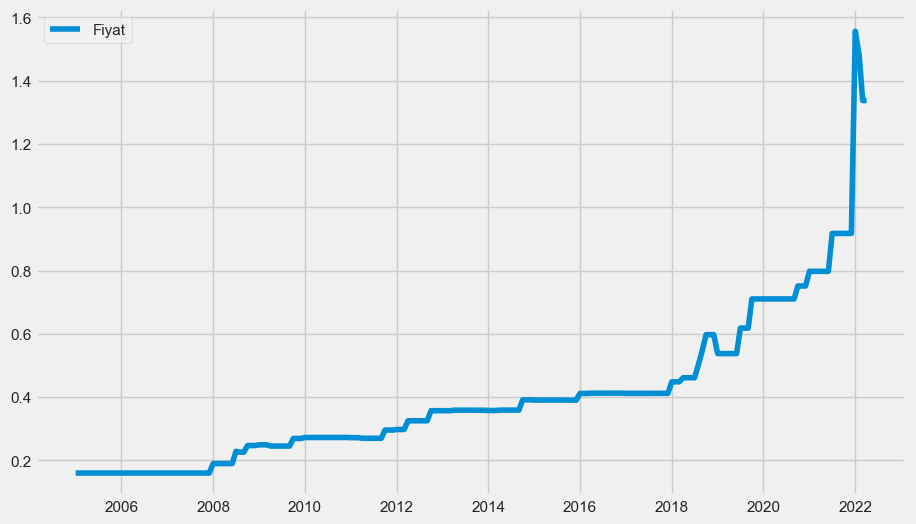

In [20]:
plt.style.use("fivethirtyeight")
pd.plotting.register_matplotlib_converters()
fig = plt.figure(figsize=(10,6))
plt.plot(df_sub.set_index("Tarih"))
plt.legend(["Fiyat"])

<b>Verinin kapsadığı tüm zaman aralığına baktığımızda ise 2005'ten 2008'in başlarına kadar fiyatın sabit olduğu, bu tarihten sonrası için ise zaman zaman sabit kalsa da genel olarak artan bir trend izlediği söylenebilir.</b>

## Prophet İle Gelecek Tahminlemesi

In [21]:
# sutun isimlerimizi kütüphanenin istediği formata getirelim
df_sub.columns = ["ds","y"]

In [22]:
df_sub.head()

,ds,y
0,2005-01-01,0.16
1,2005-02-01,0.16
2,2005-03-01,0.16
3,2005-04-01,0.16
4,2005-05-01,0.16


In [23]:
# %95 güven aralığında, 300 birimlik örneklem alan bir model nesnesi oluşturduk
m = Prophet(seasonality_mode = "multiplicative", interval_width=0.95, mcmc_samples=300)

Modelin başarısını arttırmak için Türkiye'deki resmi tatilleri de veri setine ekliyoruz. Bu sayade modelin tatillerin fiyat değişimleri üzerindeki etkisini dikkate almasını sağlayacağız. Resmi tatiller genellikle piyasalarda işlem hacminde düşüşlere, fiyat değişimlerinde ise artışlara sebep olur. Bu nedenle tatil günlerinde fiyat tahminlemesi yapılırken bu etkinin dikkate alınması model başarımını artırabilir.

In [24]:
#m.add_country_holidays(country_name="TR")

Maalesef Prophet kütüphanesinin Türkiyede'ki tatiller için tam desteği bulumuyor, kod aktifken yaptığım denemelerde anlamsız sonuçlarla karşılaştım ve bu kodu yorum satırı yapmaya karar verdim. Yani resmi tatilleri modelimize dahil etmeyeceğiz.

In [25]:
# modelimiz kuralım ve tahminleyelim
m = m.fit(df_sub)
gelecek = m.make_future_dataframe(periods=120, freq="M")
tahmin = m.predict(gelecek)
tahmin

19:10:57 - cmdstanpy - INFO - CmdStan installation C:\Users\enesm\anaconda3\lib\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
19:10:57 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
19:10:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:11:00 - cmdstanpy - INFO - CmdStan done processing.
19:11:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2005-01-01,0.130340,0.023177,0.291789,0.097088,0.163199,0.224605,0.115698,0.327800,0.224605,0.115698,0.327800,0.0,0.0,0.0,0.159615
1,2005-02-01,0.131802,0.034995,0.293286,0.099978,0.163103,0.200809,0.090194,0.315064,0.200809,0.090194,0.315064,0.0,0.0,0.0,0.158269
2,2005-03-01,0.133122,0.013213,0.270384,0.102802,0.163152,0.064794,0.001408,0.139941,0.064794,0.001408,0.139941,0.0,0.0,0.0,0.141748
3,2005-04-01,0.134584,0.017601,0.267271,0.105363,0.162999,0.065316,-0.002292,0.136119,0.065316,-0.002292,0.136119,0.0,0.0,0.0,0.143374
4,2005-05-01,0.135998,0.014250,0.258771,0.108489,0.163168,-0.018469,-0.093582,0.053353,-0.018469,-0.093582,0.053353,0.0,0.0,0.0,0.133487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,2031-11-30,2.522182,1.860316,3.716253,1.983083,3.085669,0.091334,-0.212118,0.365136,0.091334,-0.212118,0.365136,0.0,0.0,0.0,2.752542
324,2031-12-31,2.535344,1.557206,3.371326,1.988758,3.106471,-0.050917,-0.337700,0.262324,-0.050917,-0.337700,0.262324,0.0,0.0,0.0,2.406252
325,2032-01-31,2.548506,1.447873,3.206496,1.994405,3.124375,-0.111208,-0.381401,0.145278,-0.111208,-0.381401,0.145278,0.0,0.0,0.0,2.265093
326,2032-02-29,2.560819,2.344769,3.899932,1.997581,3.141326,0.204937,0.027360,0.372547,0.204937,0.027360,0.372547,0.0,0.0,0.0,3.085626


2032 senesine kadar tahminde bulunuyor. 2032'nin Mart ayı için fiyat tahmini oalrak 3.213151 sayısını getiriyor. Oldukça yüksek bir tahmin.

<table>
  <tr>
    <th>Türkçe</th>
    <th>İngilizce</th>
  </tr>
  <tr>
    <td>Tarih</td>
    <td>ds</td>
  </tr>
  <tr>
    <td>Genel Eğilim</td>
    <td>trend</td>
  </tr>
  <tr>
    <td>Tahmin Alt Sınırı</td>
    <td>yhat_lower</td>
  </tr>
  <tr>
    <td>Tahmin Üst Sınırı</td>
    <td>yhat_upper</td>
  </tr>
  <tr>
    <td>Eğilim Alt Sınırı</td>
    <td>trend_lower</td>
  </tr>
  <tr>
    <td>Eğilim Üst Sınırı</td>
    <td>trend_upper</td>
  </tr>
  <tr>
    <td>Atatürk'ü Anma Günü Tahmini Katkı Değeri</td>
    <td>Commemoration of Ataturk</td>
  </tr>
  <tr>
    <td>Atatürk'ü Anma Günü Tahmini Katkı Değeri Alt Sınırı</td>
    <td>Commemoration of Ataturk_lower</td>
  </tr>
  <tr>
    <td>Atatürk'ü Anma Günü Tahmini Katkı Değeri Üst Sınırı</td>
    <td>Commemoration of Ataturk_upper</td>
  </tr>
  <tr>
    <td>Demokrasi ve Milli Birlik Günü Tahmini Katkı Değeri</td>
    <td>Democracy and National Unity Day</td>
  </tr>
  <tr>
    <td>Çarpan Terimleri</td>
    <td>multiplicative_terms</td>
  </tr>
  <tr>
    <td>Çarpan Terimleri Alt Sınırı</td>
    <td>multiplicative_terms_lower</td>
  </tr>
  <tr>
    <td>Çarpan Terimleri Üst Sınırı</td>
    <td>multiplicative_terms_upper</td>
  </tr>
  <tr>
    <td>Yıllık Mevsimsellik Terimi</td>
    <td>yearly</td>
  </tr>
  <tr>
    <td>Yıllık Mevsimsellik Terimi Alt Sınırı</td>
    <td>yearly_lower</td>
  </tr>
  <tr>
    <td>Yıllık Mevsimsellik Terimi Üst Sınırı</td>
    <td>yearly_upper</td>
  </tr>
  <tr>
    <td>Toplama Terimleri</td>
    <td>additive_terms</td>
  </tr>
  <tr>
    <td>Toplama Terimleri Alt Sınırı</td>
    <td>additive_terms_lower</td>
  </tr>
  <tr>
    <td>Toplama Terimleri Üst Sınırı</td>
    <td>additive_terms_upper</td>
  </tr>
  <tr>
    <td>Tahmin</td>
    <td>yhat</td>
  </tr>
  <tr>


Prophet tahmin yaparken verinin başlangıcından itibaren mevcut bilgiyi kullanıyor ve bu nedenle zaten halihazırda bildiğimiz yıllar için de tahmin yapar. Ancak tahmin edilen değerler genellikle mevcut verilerden farklı çıkar çünkü Prophet, trend ve mevsimsellik bileşenlerini kullanarak gelecekteki değişimleri tahmin etmeye çalışır. Bu sebeple tahmin edilen değerlerin mevcut verilerle tam olarak örtüşmesini beklemeyiz.

## Tahminlerin Görselleştirilmesi

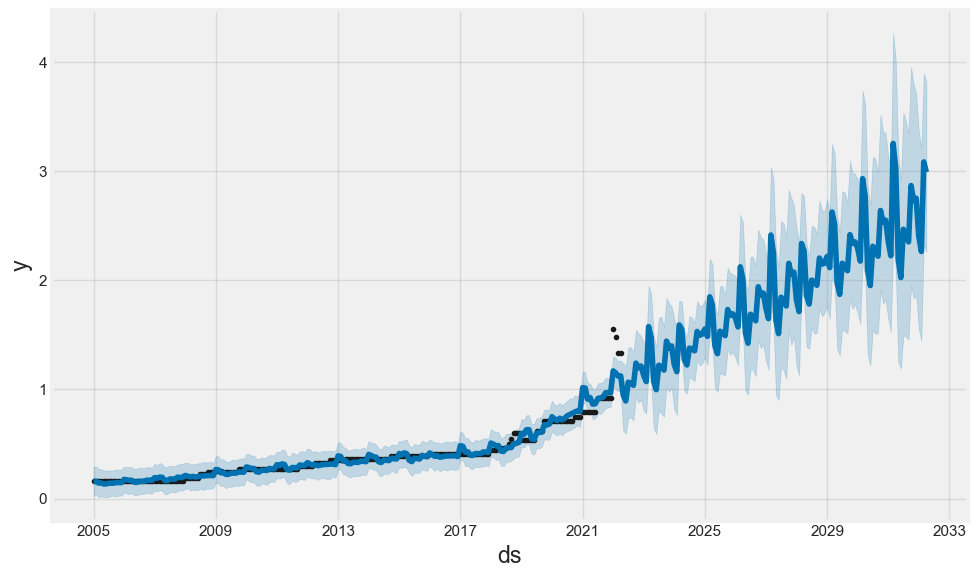

In [26]:
grafik1 = m.plot(tahmin)

Siyah noktalar gerçekleşmiş noktaları temsil eder, mavi le çizilmiş çizgi ise modelin tahminlerini ifade eder. Açık mavi ile gözüken yerler ise üst güven sınırını ve alt güven sınırını temsil eder. Siyah noktaların 2022 yılından sonrası için grafikte gözükmemesinin nedeni TUİK'ten çektiğimiz gerçek veride bu zaman dilimlerine ait veri yoktur.

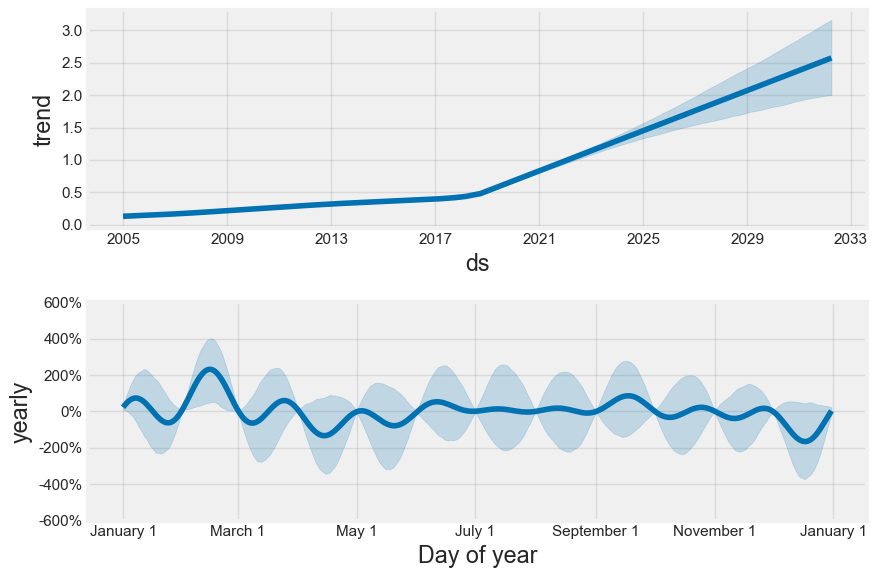

In [27]:
grafik2 = m.plot_components(tahmin)

Trend grafiğine baktığımız zaman gelecekte de fiyatların artarak devam edeceği görülüyor. Yeniden trend grafiğini incelemeye devam edersek, açık mavi ile gözüken alanın belirlediğimiz güven aralığını temsil ettiği görülür.

İkinci grafik ise ay ay fiyatlardaki artıp azalma temsil etmekte.

### 2023 senesinde elektrik fiyatları nasıl olacak?

In [28]:
tahminler = tahmin
tahminler["Yıl"] = tahminler["ds"].apply(lambda x: x.year)
tahminler["Ay"] = tahminler["ds"].apply(lambda x: x.month)

tahminler.loc[(tahminler["Yıl"] == 2023)].T

,217,218,219,220,221,222,223,224,225,226,227,228
ds,2023-01-31 00:00:00,2023-02-28 00:00:00,2023-03-31 00:00:00,2023-04-30 00:00:00,2023-05-31 00:00:00,2023-06-30 00:00:00,2023-07-31 00:00:00,2023-08-31 00:00:00,2023-09-30 00:00:00,2023-10-31 00:00:00,2023-11-30 00:00:00,2023-12-31 00:00:00
trend,1.152889,1.164777,1.17794,1.190677,1.203839,1.216577,1.229739,1.242901,1.255639,1.268801,1.281539,1.294701
yhat_lower,0.778832,1.185008,1.078196,0.643918,0.592568,0.807867,0.779427,0.749173,1.026769,0.975593,1.017207,0.821514
yhat_upper,1.387811,1.951178,1.876699,1.500657,1.382552,1.655364,1.665516,1.573781,1.839148,1.78773,1.761195,1.655316
trend_lower,1.091923,1.102169,1.114205,1.124441,1.136135,1.147464,1.159144,1.170859,1.181591,1.191787,1.202385,1.213228
trend_upper,1.21291,1.225643,1.239731,1.254152,1.269113,1.283315,1.298292,1.313848,1.329015,1.344624,1.360071,1.376175
multiplicative_terms,-0.070127,0.353079,0.251964,-0.09736,-0.171327,0.004499,-0.018777,-0.052652,0.149312,0.087694,0.091334,-0.050917
multiplicative_terms_lower,-0.286162,0.033902,-0.067137,-0.442331,-0.485901,-0.313132,-0.338915,-0.377203,-0.163728,-0.22797,-0.212118,-0.3377
multiplicative_terms_upper,0.145992,0.672986,0.564982,0.253382,0.13704,0.326118,0.329642,0.25021,0.453141,0.419888,0.365136,0.262324
yearly,-0.070127,0.353079,0.251964,-0.09736,-0.171327,0.004499,-0.018777,-0.052652,0.149312,0.087694,0.091334,-0.050917


#### Direkt ay ay 2023 tahminleri

In [29]:
tahminler.loc[(tahminler["Yıl"] == 2023), ['Ay', 'yhat']].replace({1: 'Ocak', 2: 'Şubat', 3: 'Mart', 4: 'Nisan', 5: 'Mayıs', 6: 'Haziran', 7: 'Temmuz', 8: 'Ağustos', 9: 'Eylül', 10: 'Ekim', 11: 'Kasım', 12: 'Aralık',})

,Ay,yhat
217,Ocak,1.072040
218,Şubat,1.576035
219,Mart,1.474738
220,Nisan,1.074753
221,Mayıs,0.997589
222,Haziran,1.222050
223,Temmuz,1.206649
224,Ağustos,1.177460
225,Eylül,1.443121
226,Ekim,1.380067


Önümüzdeki dönemde fiyatlar belli olacak, bakalım modelimiz ne kadar başarılı tahminler yapmış?

İşlem tarihi: 02.03.2023

Bu tahminleri 2005'in Ocak ayından 2022'nin Nisan ayına kadar olan veriden çıkardı.

Günümüz fiyatlarına baktığımda, modelin güncele göre daha düşük tahminlerde bulunduğu söylenebilir.